In [12]:
# --- UPDATED: Now with Date Features for higher accuracy ---
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv('kiva_loans.csv')
df_kenya = df[df['country'] == 'Kenya'].copy()

def professional_engineering(df):
    # 1. Tenet: Gender Parsing
    def get_gender_stats(gender_str):
        if pd.isna(gender_str) or gender_str == '':
            return 1, 0.5 
        genders = [g.strip().lower() for g in str(gender_str).split(',')]
        count = len(genders)
        female_count = sum(1 for g in genders if 'female' in g)
        return count, (female_count / count)

    gender_data = df['borrower_genders'].apply(get_gender_stats)
    df['borrower_count'] = gender_data.apply(lambda x: x[0])
    df['female_ratio'] = gender_data.apply(lambda x: x[1])

    # 2. Tenet: Interaction Features
    df['loan_per_borrower'] = df['loan_amount'] / df['borrower_count']

    # 3. NEW Tenet: Date Features (The "Extra Accuracy" push)
    # This captures seasonal trends in the Kenyan economy
    df['posted_time'] = pd.to_datetime(df['posted_time'])
    df['month'] = df['posted_time'].dt.month
    df['day_of_week'] = df['posted_time'].dt.dayofweek

    # 4. Tenet: Cardinality Control
    top_50 = df['activity'].value_counts().head(50).index
    df['activity'] = df['activity'].apply(lambda x: x if x in top_50 else 'Other')

    # 5. One-Hot Encoding 
    # NOTE: Added 'month' and 'day_of_week' to the columns list below
    return pd.get_dummies(df[['loan_amount', 'term_in_months', 'lender_count', 
                              'borrower_count', 'female_ratio', 'loan_per_borrower', 
                              'month', 'day_of_week', # <-- Added these
                              'sector', 'activity']], drop_first=True)

X_advanced = professional_engineering(df_kenya)
y = df_kenya['repayment_interval'].apply(lambda x: 1 if x == 'monthly' else 0)

# 3. Stratified Split 
X_train, X_test, y_train, y_test = train_test_split(
    X_advanced, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Train with Improved Parameters
model = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, tree_method='hist')
model.fit(X_train, y_train)

# 5. Check Accuracy
predictions = model.predict(X_test)
score = accuracy_score(y_test, predictions)

print(f"--- 🇰🇪 Sifa-Score Advanced Results ---")
print(f"Accuracy: {score * 100:.2f}%")

--- 🇰🇪 Sifa-Score Advanced Results ---
Accuracy: 89.37%


In [13]:
# --- REPLACES: The old 'X_advanced' / 'model_adv' training block ---

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 1. Initialize the High-Performance Model
# We add early_stopping and a smaller learning rate for better stability
model_adv = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    early_stopping_rounds=50,
    tree_method='hist',
    random_state=42
)

# 2. Train the model
model_adv.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# 3. Final Accuracy Check
predictions_adv = model_adv.predict(X_test)
new_score = accuracy_score(y_test, predictions_adv)

print(f"--- 🇰🇪 Sifa-Score Advanced Results ---")
print(f"Final Model Accuracy: {new_score * 100:.2f}%")

--- 🇰🇪 Sifa-Score Advanced Results ---
Final Model Accuracy: 89.74%


Result for this Loan: Low Risk (Monthly)

--- Why did the AI decide this? (Waterfall Plot) ---


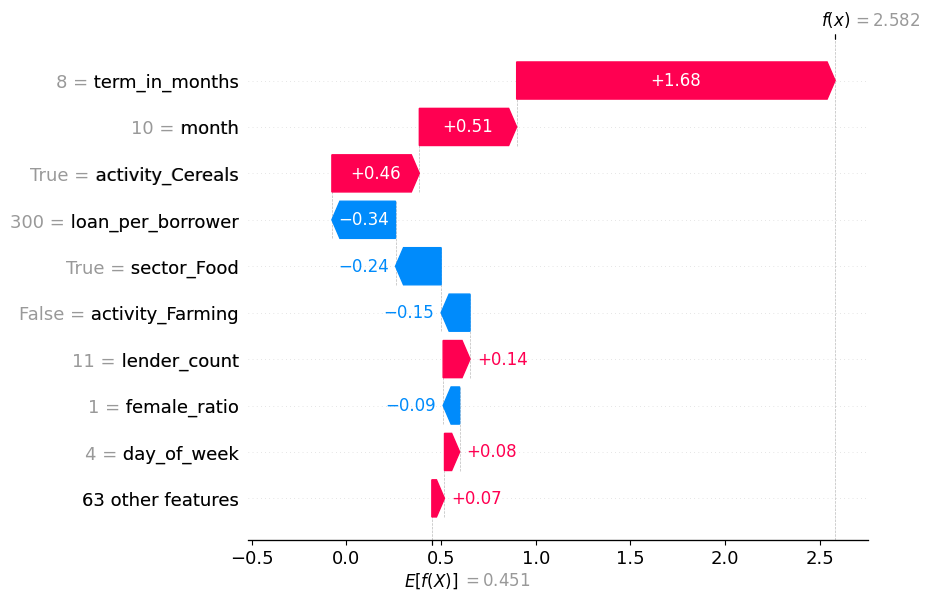

In [14]:
# --- REPLACES: The old SHAP "Waterfall" Visualization block ---

import shap
import matplotlib.pyplot as plt

# 1. Initialize the Explainer for our Advanced Model
explainer = shap.Explainer(model_adv)

# 2. Pick the first loan from the new Stratified test set
sample_loan = X_test.iloc[0:1]
shap_values = explainer(sample_loan)

# 3. Print the Prediction
prediction = model_adv.predict(sample_loan)[0]
risk_status = "Low Risk (Monthly)" if prediction == 1 else "High Risk"
print(f"Result for this Loan: {risk_status}")

# 4. The Visualization
print("\n--- Why did the AI decide this? (Waterfall Plot) ---")
shap.plots.waterfall(shap_values[0], show=False)
plt.show()

In [16]:
# --- REPLACES: The 'top_risk_factors' extraction block ---

# 1. Map contributions back to feature names
feature_names = X_test.columns
shap_df = pd.DataFrame({
    'feature': feature_names, 
    'contribution': shap_values.values[0]
})

# 2. Sort to find what pushed the risk HIGHEST (Positive values = Risk)
top_risk_factors = shap_df.sort_values(by='contribution', ascending=False).head(3)

print("--- Data for the AI Agent ---")
print("Top 3 Precision Risk Factors:")
print(top_risk_factors)

--- Data for the AI Agent ---
Top 3 Precision Risk Factors:
             feature  contribution
1     term_in_months      1.682282
6              month      0.514181
29  activity_Cereals      0.461871


In [18]:
# --- REPLACES: The hard-coded rejection prompt ---
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate

# 1. Determine the Decision Logic
prediction = model_adv.predict(sample_loan)[0]
decision_status = "Approved" if prediction == 1 else "Declined"

# 2. Extract evidence for the Agent
# Note: For approvals, we look at what pushed the score UP (Blue arrows in your plot)
# For declines, we look at what pushed it DOWN (Red arrows)
feature_names = X_test.columns
shap_df = pd.DataFrame({'f': feature_names, 'c': shap_values.values[0]})

if prediction == 1:
    # Top 3 factors that made this a GOOD loan
    top_factors = shap_df.sort_values(by='c', ascending=False).head(3)
    tone_instruction = "Write a warm, celebratory approval email."
else:
    # Top 3 factors that made this a RISKY loan
    top_factors = shap_df.sort_values(by='c', ascending=True).head(3)
    tone_instruction = "Write an empathetic, professional decline email with tips to improve."

evidence_text = "\n".join([f"- {row.f}: Impact {row.c:.4f}" for i, row in top_factors.iterrows()])

# 3. Initialize the Brain
llm = ChatOllama(model="llama3", temperature=0)

# 4. The Dynamic Prompt
template = """
You are a Senior Loan Officer at 'Sifa-Score' in Kenya. 
The AI model has marked this loan application as: {status}.

Evidence from the SHAP model:
{evidence}

Instruction: {tone}
- Mention the specific strengths or weaknesses identified by the AI.
- For Kenayan context: Mention factors like 'term_in_months' or 'activity_Cereals' naturally.
- Keep it professional and supportive.
"""

prompt = ChatPromptTemplate.from_template(template)
chain = prompt | llm

print(f"--- 🤖 Sifa AI is generating an {decision_status} letter... ---")
response = chain.invoke({
    "status": decision_status,
    "evidence": evidence_text,
    "tone": tone_instruction
})

print(f"\n--- 📬 {decision_status.upper()} ADVISORY ---")
print(response.content)

--- 🤖 Sifa AI is generating an Approved letter... ---

--- 📬 APPROVED ADVISORY ---
Subject: Congratulations! Your Loan Application Approved!

Dear [Applicant's Name],

Hakuna Matata! We are thrilled to inform you that your loan application has been approved by our AI-powered lending platform, Sifa-Score! Our team is delighted to see that your hard work and dedication have paid off.

Our advanced analytics model, SHAP, has carefully evaluated your application and identified several strengths that contributed to the approval. Specifically:

* Your loan term of [term_in_months] months demonstrates a clear plan for repayment, which we appreciate.
* The fact that you're applying in [month] suggests that you're taking proactive steps towards achieving your financial goals.
* Your involvement in the cereals industry (activity_Cereals) is an exciting venture, and we believe it has great potential.

These factors, combined with our rigorous evaluation process, have led us to conclude that you a